# **Deteksi Plat Nomor Kendaraan Menggunakan Convolutional Neural Network**

Anggota:


1.   Ekfa Ediet Hamara - 1301213360
2.   Citra Aulia Sakinah - 1301213216

## Library

In [33]:
import matplotlib.pyplot as plt

In [34]:


import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential,model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten,MaxPool2D, MaxPooling2D, Dropout, Conv2D
from sklearn.model_selection import train_test_split

## 1. Pengolahan Gambar untuk Deteksi Plat Nomor

* deteksi plat nomor kendaraan menggunakan metode deteksi objek berbasis Cascade Classifier dari OpenCV
* Menggunakan file classifier XML untuk deteksi plat nomor indian_license_plate.xml 

source dataset:
[https://www.kaggle.com/datasets/sarthakvajpayee/ai-indian-license-plate-recognition-data]

In [35]:
def extract_plate(img): # the function detects and performs blurring on the number plate.
    plate_img = img.copy()
    
    #Loads the data required for detecting the license plates from cascade classifier.
    plate_cascade = cv2.CascadeClassifier('./indian_license_plate.xml')

    # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.6, minNeighbors = 7)

    for (x,y,w,h) in plate_rect:
        a,b = (int(0.02*img.shape[0]), int(0.025*img.shape[1])) #parameter tuning
        plate = plate_img[y+a:y+h-a, x+b:x+w-b, :]
        # finally representing the detected contours by drawing rectangles around the edges.
        cv2.rectangle(plate_img, (x,y), (x+w, y+h), (51,51,255), 3)
        
    return plate_img, plate # returning the processed image.

Fungsi di atas bekerja dengan mengambil gambar sebagai input, kemudian menerapkan 'Haar Cascade' yang telah dilatih sebelumnya untuk mendeteksi pelat nomor India. Parameter scaleFactor adalah nilai yang digunakan untuk mengatur skala gambar input sehingga pendeteksian pelat nomor lebih baik (pelajari lebih lanjut). minNeighbors adalah parameter untuk mengurangi hasil positif palsu; jika nilai ini rendah, algoritma mungkin lebih rentan menghasilkan keluaran yang salah atau salah dikenali.

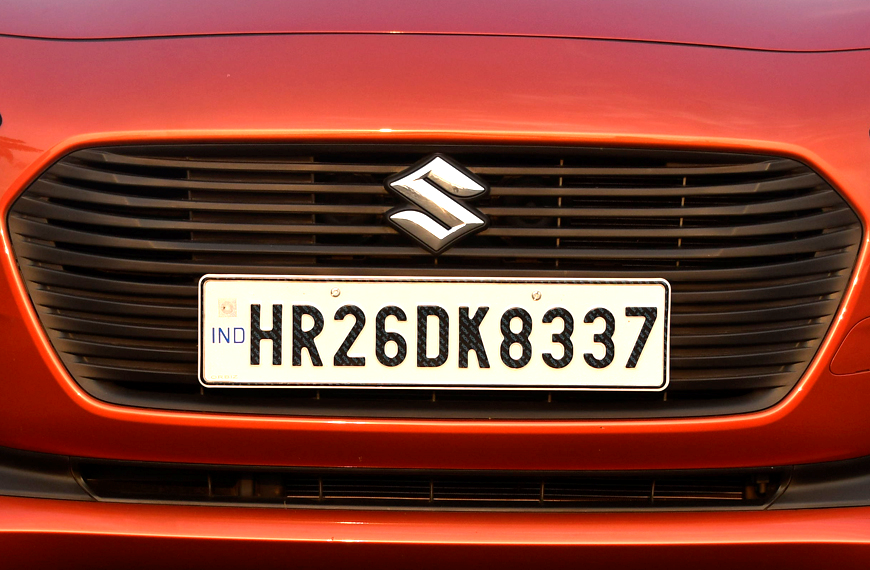

In [36]:
from IPython.display import Image
#image used for extracting number plate
Image(filename='swift.png') 

In [37]:
plate_img2,plate1 = extract_plate(cv2.imread('swift.png'))

In [38]:
#writing the image into a png file
cv2.imwrite('car_plate.png',plate1)

True

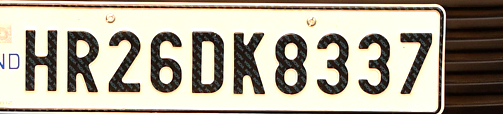

In [39]:
#image generated from the extract_plate is seen here
Image(filename='car_plate.png') 

## 2. Segmentasi dan Deteksi Karakter dari Plat Nomor

Mendeteksi dan mengekstraksi karakter-karakter (angka atau huruf) dari plat nomor setelah plat nomor terdeteksi.

### Mencari Contours: Gambar plat nomor yang telah dipotong dan dimasukkan ke dalam format biner (hitam-putih)

In [40]:
import numpy as np
import cv2

# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

#             Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)
            
    #Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

Setelah menemukan semua kontur, kita mempertimbangkan kontur-kontur tersebut satu per satu dan menghitung dimensi dari bounding rectangle masing-masing. Bounding rectangle adalah persegi panjang terkecil yang dapat menampung sebuah kontur.

* Bounding rectangle adalah persegi panjang dengan ukuran yang cukup untuk mengelilingi kontur tersebut, meminimalkan ruang kosong di sekitar objek.
* Untuk setiap kontur yang terdeteksi, kita dapat menggambar persegi panjang ini untuk visualisasi dan menentukan batasan dari karakter pada pelat nomor.

Dengan menggambar bounding rectangle di sekitar setiap karakter, kita bisa lebih mudah memisahkan setiap bagian dari pelat nomor dan memprosesnya lebih lanjut untuk ekstraksi karakter atau pengenalan karakter.

### Segmentation Characters

In [41]:
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

1. Mengubah ukuran gambar:
Gambar diubah ukurannya menjadi dimensi tertentu sehingga semua karakter terlihat jelas dan mudah dibedakan.

2. Mengonversi gambar berwarna menjadi gambar skala abu-abu:
Gambar berwarna (dengan tiga saluran: BGR) diubah menjadi gambar skala abu-abu, sehingga hanya memiliki satu saluran 8-bit dengan nilai antara 0–255. Nilai 0 mewakili hitam, sedangkan 255 mewakili putih. Langkah ini dilakukan untuk menyiapkan gambar untuk proses berikutnya.

3. Menggunakan fungsi threshold untuk menghasilkan gambar biner:
Gambar skala abu-abu diubah menjadi gambar biner. Dalam gambar biner, setiap piksel memiliki nilai 0 (hitam) atau 1 (putih). Threshold ditetapkan pada nilai tertentu, misalnya 200, sehingga piksel dengan nilai lebih dari 200 akan diberi nilai 1 dalam gambar biner, sedangkan piksel dengan nilai di bawah 200 akan diberi nilai 0.

4. Proses eroding:
Gambar biner yang dihasilkan kemudian diproses menggunakan metode eroding untuk menghapus piksel yang tidak diinginkan di tepi objek (piksel yang seharusnya 0 tetapi memiliki nilai 1). Eroding bekerja dengan memeriksa setiap piksel satu per satu, bersama dengan tetangganya (jumlah tetangga tergantung pada ukuran kernel). Sebuah piksel diberi nilai 1 hanya jika semua tetangganya bernilai 1, jika tidak maka diberi nilai 0.

5. Proses dilating:
Setelah eroding, gambar menjadi bersih dari noise batas. Selanjutnya, gambar diproses menggunakan metode dilating untuk mengisi piksel yang hilang (piksel yang seharusnya 1 tetapi memiliki nilai 0). Proses ini bekerja dengan memeriksa setiap piksel satu per satu bersama dengan tetangganya. Sebuah piksel diberi nilai 1 jika setidaknya salah satu tetangganya memiliki nilai 1.

6. Membuat batas gambar berwarna putih:
Langkah berikutnya adalah membuat semua batas gambar menjadi putih. Ini dilakukan untuk menghilangkan piksel apa pun yang berada di luar bingkai jika ada.

7. Mendefinisikan daftar dimensi untuk menyaring karakter:
Daftar dimensi didefinisikan, berisi empat nilai, yang akan digunakan untuk membandingkan dimensi karakter dalam gambar guna menyaring karakter yang diperlukan.

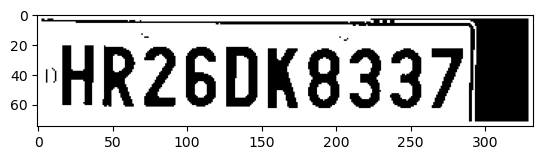

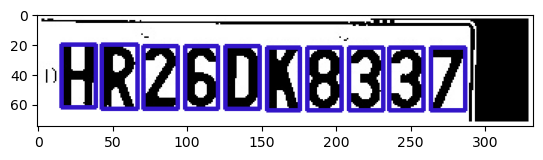

In [42]:
img = cv2.imread('car_plate.png')
char = segment_characters(img)

Melakukan beberapa penyetelan parameter dan menyaring persegi panjang yang diperlukan yang berisi karakter yang diperlukan. Untuk ini, kita akan melakukan beberapa perbandingan dimensi dengan hanya menerima persegi panjang yang memiliki:

1. Lebar dalam kisaran:
0 hingga (panjang gambar) / (jumlah karakter), yaitu lebar yang proporsional dengan jumlah karakter yang ada di pelat nomor.

3. Panjang dalam kisaran:
(lebar gambar) / 2 hingga 4 * (lebar gambar) / 5, yaitu panjang yang sesuai dengan ukuran karakter pada pelat nomor.

Dengan melakukan perbandingan ini, kita dapat menyaring persegi panjang yang tidak relevan atau terlalu kecil/besar yang bukan merupakan karakter pada pelat nomor.

Jika semuanya berjalan dengan baik, kita akan berhasil mengekstrak semua karakter sebagai gambar biner, siap untuk diproses lebih lanjut dalam langkah berikutnya, seperti pengenalan karakter.

In [43]:
#shape of the char array generated from the segment_characters function
char.shape

(10, 44, 24)

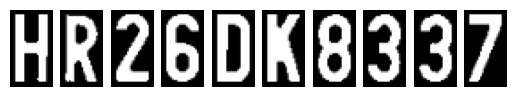

In [44]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

## 3. MODEL TRAINING

Pelatihan Model untuk Klasifikasi Karakter

In [45]:
import tensorflow as tf

### Menggunakan ImageDataGenerator untuk melakukan augmentasi

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        'data/val',  # this is the target directory
        target_size=(28,28), batch_size=1,
        class_mode='categorical')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


### Model CNN (Convolutional Neural Network)

1. Komponen Model:
    * Convolutional layers untuk mendeteksi fitur-fitur dari gambar karakter.
    * MaxPooling untuk mengurangi dimensi gambar setelah fitur diekstraksi.
    * Dropout untuk mencegah overfitting dengan menonaktifkan beberapa neuron secara acak selama pelatihan.
    * Dense layers untuk mengklasifikasikan karakter dengan jumlah kelas 36 (angka 0-9 dan huruf A-Z).

2. Kompilasi Model: Menggunakan Adam optimizer dan categorical crossentropy loss function untuk multi-class classification.

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras import optimizers

In [48]:
model = Sequential()
model.add(Conv2D(32, (24,24), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.00001), metrics=['accuracy'])

c:\Users\ekfahamara\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [49]:
import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [50]:
batch_size = 1
callbacks = [tensorboard_callback,tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)]
history = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples // batch_size,
      epochs = 20, callbacks=callbacks)

c:\Users\ekfahamara\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 99s 110ms/step - accuracy: 0.0465 - loss: 3.5502 - val_accuracy: 0.1435 - val_loss: 3.0672
Epoch 2/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 96s 112ms/step - accuracy: 0.2144 - loss: 2.8209 - val_accuracy: 0.5185 - val_loss: 1.7893
Epoch 3/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 92s 106ms/step - accuracy: 0.5147 - loss: 1.6753 - val_accuracy: 0.6667 - val_loss: 1.1586
Epoch 4/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 108s 125ms/step - accuracy: 0.6275 - loss: 1.1573 - val_accuracy: 0.7685 - val_loss: 0.8825
Epoch 5/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 111s 128ms/step - accuracy: 0.7088 - loss: 0.9837 - val_accuracy: 0.7870 - val_loss: 0.7511
Epoch 6/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 106s 123ms/step - accuracy: 0.7115 - loss: 0.8543 - val_accuracy: 0.8611 - val_loss: 0.5858
Epoch 7/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 112s 129ms/step - accuracy: 0.7788 - loss: 0.6670 - val_accuracy: 0.8935 - val_loss: 0.4523
Epoch 8/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 115s 133ms/step - accuracy: 0.7960 - lo

In [51]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


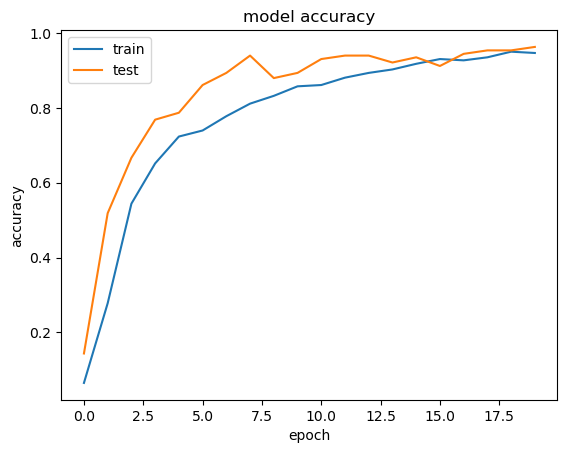

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1. Accuracy (akurasi pada data latih) meningkat secara konsisten dari 4.65% pada Epoch 1 menjadi 95.67% pada Epoch 20.
2. Val_Accuracy (akurasi pada data validasi) juga meningkat dari 14.35% pada Epoch 1 menjadi 96.30% pada Epoch 20.

- Pada awalnya, terdapat gap yang besar antara accuracy dan val_accuracy, menunjukkan bahwa model mulai memahami pola data.
- Setelah beberapa epoch (sekitar Epoch 6-10), gap ini mengecil, menunjukkan bahwa model belajar lebih baik tanpa overfitting.

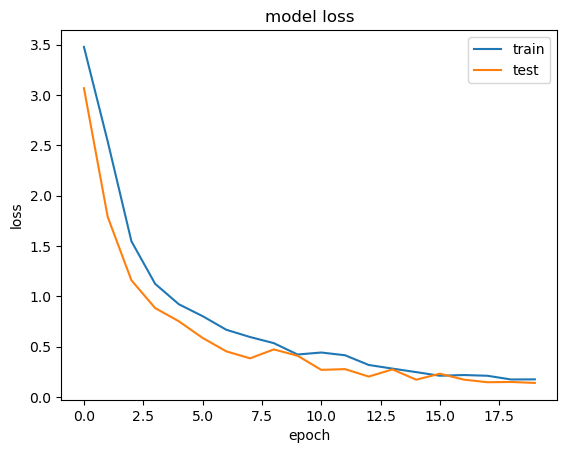

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

1. Loss (kerugian pada data latih) menurun dari 3.5502 pada Epoch 1 menjadi 0.1663 pada Epoch 20, menunjukkan bahwa model semakin baik memprediksi data latih.
2. Val_Loss (kerugian pada data validasi) menurun dari 3.0672 pada Epoch 1 menjadi 0.1388 pada Epoch 20.
- Val_Loss mulai stabil setelah Epoch 13, menandakan bahwa model telah mencapai generalisasi yang baik.

In [54]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │        55,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │       409,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │       409,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,046,542 (19.25 MB)

 Trainable params: 1,682,180 (6.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,364,362 (12.83 MB)

   #### SAVING AND LOADING MODEL

In [65]:
# Mengimpor fungsi dari model_utils.py
from model_utils import store_keras_model, load_keras_model

# Menyimpan model
store_keras_model(model, 'model1')

# Memuat model
pre_trained_model = load_keras_model('model1')

# Menggunakan model yang telah dimuat
new_model = pre_trained_model

# Melihat ringkasan model
new_model.summary()


Model berhasil disimpan ke disk.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │        55,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │       409,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │       409,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,046,542 (19.25 MB)

 Trainable params: 1,682,180 (6.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,364,362 (12.83 MB)

## 4. MODEL PREDICTION

Memprediksi karakter-karakter dalam plat nomor yang telah tersegmentasi.

### mengubah dimensi gambar karakter menjadi ukuran 28x28 dengan 3 channel untuk digunakan dalam model.

In [66]:
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for i, ch in enumerate(char):  # iterating over the characters
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1, 28, 28, 3)  # preparing image for the model
        probabilities = new_model.predict(img)  # predicting the class probabilities
        y_ = np.argmax(probabilities, axis=1)[0]  # finding the class with highest probability
        character = dic[y_]
        output.append(character)  # storing the result in a list
        
    plate_number = ''.join(output)
    return plate_number
print(show_results())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
HRZ80K8337


### Memprediksi karakter untuk setiap potongan gambar karakter

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

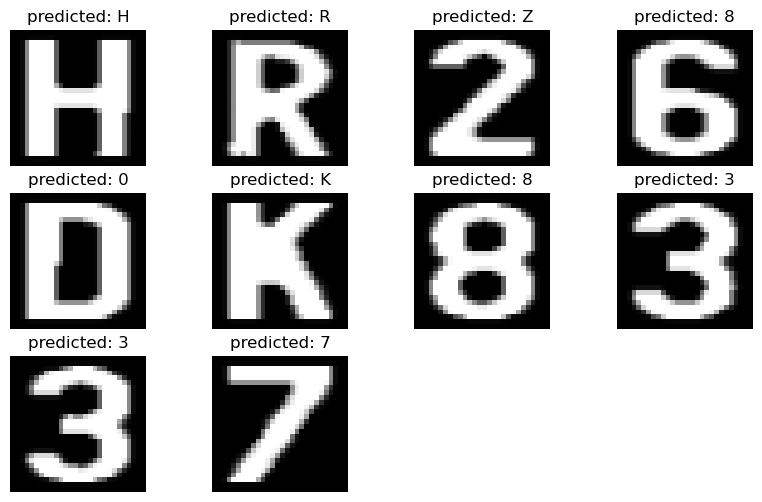

In [67]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28))
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()